In [22]:
# Example usage: customize these paths and (optionally) the seed/column.
JSON_PATH =  "labeled_data_nano41_sanmartino_baseline_fairprompt_highonly.json" # Json file (in the same order as golden test set!) with the model outputs 
PICKLE_PATH = "golden_test_set_martino_extended_integer.pkl" # Sahitaj / DaSanMartino Golden Test Set
#PICKLE_PATH = "golden_test_set_with_ids_extended" # Our Schema Golden Test Set
SEED = 42  # not neccessary, artifact
PICKLE_COLUMN = "high"
JSON_KEY = "high"

In [23]:
import json
import random
from collections import Counter
from typing import Any, Iterable, List, Sequence, Tuple

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix


def _coerce_int(x: Any) -> int:
    """Try to coerce a scalar to int (handles strings like '3')."""
    if isinstance(x, (np.integer,)):
        return int(x)
    if isinstance(x, (int,)):
        return x
    if isinstance(x, str):
        x = x.strip()
        # Allow things like "3" or "3.0"
        try:
            return int(x)
        except ValueError:
            try:
                return int(float(x))
            except ValueError:
                pass
    raise ValueError(f"Cannot coerce value to int: {x!r}")


def _choose_from_maybe_list(x: Any, rng: random.Random, use_first: bool = True) -> int:
    """
    If x is a list/tuple/np.ndarray/pd.Series:
      - choose a random element with rng unless use_first is True,
      - otherwise return the first element.
    Otherwise, coerce x to int and return it.
    """
    if isinstance(x, (list, tuple, np.ndarray, pd.Series)):
        seq = list(x)
        if not seq:
            raise ValueError("Encountered an empty list; cannot choose a value.")
        if use_first:
            return _coerce_int(seq[0])
        return _coerce_int(rng.choice(seq))

    if x is None:
        return -1
    return _coerce_int(x)


def _extract_json_labels(json_path: str, rng: random.Random, analysis) -> List[int]:
    """
    JSON is expected to be a list of dicts, each with:
        item[JSON_KEY] = int or list[int]
    (Assumes JSON_KEY is defined by caller/module.)
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if not isinstance(data, list):
        raise TypeError("Expected top-level JSON to be a list.")

    labels = []
    for idx, item in enumerate(data):
        try:
            if(~analysis):
                value = item[JSON_KEY]  # JSON_KEY is expected to be defined by the caller
            else:
                print(item.keys())
                value = item['analysis_result'][JSON_KEY]  # JSON_KEY is expected to be defined by the caller
        except (KeyError, TypeError):
            raise KeyError(f"Missing JSON_KEY ({JSON_KEY!r}) at index {idx}")
        labels.append(_choose_from_maybe_list(value, rng))

    return labels


def _extract_pickle_preds(
    pickle_path: str, rng: random.Random, column: str = "main"
) -> List[int]:
    """
    Loads a DataFrame pickle and reads the specified column. Each cell can be
    an int or a list of ints; for lists, a random element is chosen.
    """
    df = pd.read_pickle(pickle_path)
    if column not in df.columns:
        raise KeyError(f"Column {column!r} not found in pickle. Columns: {list(df.columns)}")
    return [_choose_from_maybe_list(v, rng, use_first=True) for v in df[column].tolist()]


def _f1_macro_at_k(y_true: Sequence[int], y_pred: Sequence[int], k: int = 5) -> float:
    """
    Macro-F1 over the subset of labels whose *true* support is >= k.
    If no labels meet the threshold, returns 0.0.
    """
    counts = Counter(y_true)
    eligible = sorted([lbl for lbl, c in counts.items() if c >= k])
    if not eligible:
        return 0.0

    # Keep only positions where the true label is eligible
    idx = [i for i, yt in enumerate(y_true) if yt in eligible]
    y_true_f = [y_true[i] for i in idx]
    y_pred_f = [y_pred[i] for i in idx]

    return f1_score(
        y_true_f,
        y_pred_f,
        labels=eligible,      # ensure macro is averaged only across eligible classes
        average="macro",
        zero_division=0,
    )


def evaluate_json_vs_pickle(
    json_path: str,
    pickle_path: str,
    seed: int = 42,
    pickle_column: str = "high",
    analysis: bool=False
) -> Tuple[float, float, float, np.ndarray, List[int], List[int]]:
    """
    Returns:
      (f1_macro_true_only, f1_weighted, f1_at5_macro, confusion_matrix, y_true, y_pred)

    Notes:
      - Aligns by index; if lengths differ, truncates to the minimum length.
      - Uses 'seed' for both random selections to keep it reproducible.
      - Macro-F1 here averages over labels that appear in y_true only (not the union).
      - Confusion matrix is computed over the same y_true label set for consistency.
    """
    rng = random.Random(seed)

    y_pred = _extract_json_labels(json_path, rng, analysis=analysis)
    # For reproducibility, use a *fresh* RNG with the same seed for predictions as well,
    # so that choices in the two sources are independent but deterministic.
    rng_pred = random.Random(seed)

    y_true = _extract_pickle_preds(pickle_path, rng_pred, column=pickle_column)

    n = min(len(y_true), len(y_pred))
    if n == 0:
        raise ValueError("No overlapping indices to evaluate (after alignment, length is 0).")

    y_true = y_true[:n]
    y_pred = y_pred[:n]

    print(f"Labels in y_pred: {len(y_pred)}")
    print(f"Labels in y_true: {len(y_true)}")

    # --- Key change: macro over TRUE classes only ---
    true_labels = np.unique(y_true)

    f1_macro_true_only = f1_score(
        y_true, y_pred, labels=true_labels, average="macro", zero_division=0
    )
    f1_weighted = f1_score(
        y_true, y_pred, labels=true_labels, average="weighted", zero_division=0
    )
    f1_at5_macro = _f1_macro_at_k(y_true, y_pred, k=5)

    # Confusion matrix over the same true label set (rows=true, cols=pred for these labels)
    cm = confusion_matrix(y_true, y_pred, labels=true_labels)

    return f1_macro_true_only, f1_weighted, f1_at5_macro, cm, y_true, y_pred


if __name__ == "__main__":
    # ---- run evaluation ----
    f1_macro, f1_weighted, f1_at5_macro, cm, y_true, y_pred = evaluate_json_vs_pickle(
        JSON_PATH, PICKLE_PATH, seed=SEED, pickle_column=PICKLE_COLUMN, analysis=False
    )

    # ---- print results ----
    print(f"Items evaluated          : {len(y_true)}")
    print(f"F1 (macro, true-only)    : {f1_macro:.6f}")
    print(f"F1 (weighted, true-only) : {f1_weighted:.6f}")
    print(f"F1@5 (macro)             : {f1_at5_macro:.6f}")
    print("Confusion matrix (rows=true, cols=pred; true-label set only):")
    print(cm)

Labels in y_pred: 200
Labels in y_true: 200
Items evaluated          : 200
F1 (macro, true-only)    : 0.271746
F1 (weighted, true-only) : 0.404707
F1@5 (macro)             : 0.330403
Confusion matrix (rows=true, cols=pred; true-label set only):
[[ 4  0  0  6  0  1]
 [ 1  0  0  1  0  0]
 [ 3  0  4 15  0  0]
 [ 1  0  2 35  0  0]
 [ 0  0  4 18  1  4]
 [ 1  0  4 55  1 39]]


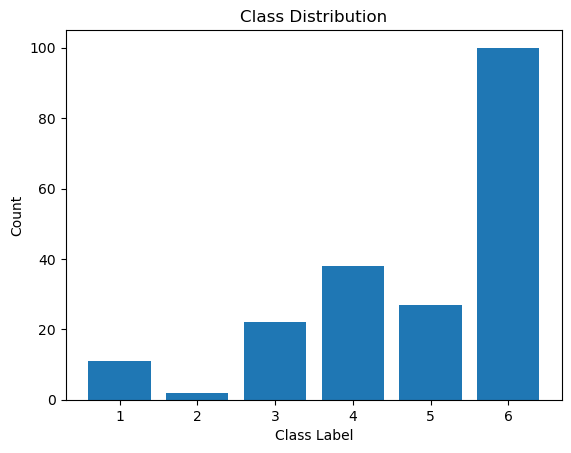

In [19]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution_skip_y(labels, y=7, save_path="class_distribution_ours1.png"):
    # Flatten single-element lists like [18] -> 18
    flat = [x[0] if isinstance(x, (list, tuple)) and len(x) == 1 else x for x in labels]
    # Remove rows where label == 18
    filtered = [x for x in flat if x != y]
    # Count classes
    counts = Counter(filtered)

    # Sort by class label for nice ordering
    classes = sorted(counts.keys())
    values = [counts[c] for c in classes]

    # Plot
    plt.bar(classes, values)
    plt.xticks(classes)
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.title(f"Class Distribution")

    # Save before showing
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

# Example usage:
plot_class_distribution_skip_y(y_true)